# Estimates

In [65]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels.iv import IV2SLS
from patsy import dmatrix, build_design_matrices

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import parallel_backend

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
panel_dataset = pd.read_csv('data/panel_dataset')
panel_dataset = panel_dataset.set_index(['person', 'day'])
panel_dataset = panel_dataset.drop(columns='Unnamed: 0')
panel_dataset['income'] = panel_dataset.income / 1000
panel_dataset['became_member_on'] = panel_dataset.became_member_on / 365.25
day_one = pd.read_csv('data/day_one_dataset')
day_one = day_one.set_index('person')

In [3]:
panel_dataset.head()

offered_0b1e1539f2cc45b7b9fa7c272da2e1d7  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_2298d6c36e964ae4a3e7e9706d1fb8c2  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_2906b810c7d4411798c6938adc9daaa5  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_3f207df678b143eea3cee63160fa8bed  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_4d5c57ea9a6940dd891ad53e9dbe8da0  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_5a8bc65990b245e5a138643cd4eb9837  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

                                      offered_9b98b8c7a33c4b65b9aebfe6a799e6d9  \
person                           day                                             
0009655768c64bdeb2e877511632db8f 1                                         0.0   
                                 2                                         0.0   
                                 3                                         0.0   
                                 4                                         0.0   
                                 5                                         0.0   

             

In [4]:
# person effects
y = panel_dataset['revenue']
X = panel_dataset[['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_3f207df678b143eea3cee63160fa8bed',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_5a8bc65990b245e5a138643cd4eb9837',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']]
model = PanelOLS(y, X, entity_effects=True, time_effects=False)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/fe_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

Dep. Variable:,revenue,R-squared:,0.0014
Estimator:,PanelOLS,R-squared (Between):,0.3019
No. Observations:,510000,R-squared (Within):,0.0014
Date:,"Sun, Jul 28 2019",R-squared (Overall):,0.0219
Time:,15:14:26,Log-likelihood,-2.313e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,69.432
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(10,492990)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,67.173


In [5]:
# person effects with time dummies
df = panel_dataset.reset_index()
df['time'] = df.day
df = df.set_index(['person', 'day'])

formula = 'revenue ~ ' + \
           'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
           'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
           'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
           'offered_3f207df678b143eea3cee63160fa8bed + ' + \
           'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
           'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
           'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
           'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
           'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
           'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
           'C(time) + EntityEffects'
                  
model = PanelOLS.from_formula(formula, df)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/fe_time_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

Dep. Variable:,revenue,R-squared:,0.0026
Estimator:,PanelOLS,R-squared (Between):,0.0061
No. Observations:,510000,R-squared (Within):,0.0026
Date:,"Sun, Jul 28 2019",R-squared (Overall):,0.0028
Time:,15:14:34,Log-likelihood,-2.313e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,32.812
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(39,492961)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,1.629e+04


In [6]:
# no fixed effects yes time dummies
formula = 'revenue ~ ' + \
           'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
           'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
           'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
           'offered_3f207df678b143eea3cee63160fa8bed + ' + \
           'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
           'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
           'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
           'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
           'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
           'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
           'TimeEffects + 1'
                  
model = PanelOLS.from_formula(formula, panel_dataset)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/time_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

Dep. Variable:,revenue,R-squared:,0.0012
Estimator:,PanelOLS,R-squared (Between):,0.0066
No. Observations:,510000,R-squared (Within):,0.0013
Date:,"Sun, Jul 28 2019",R-squared (Overall):,0.0015
Time:,15:14:37,Log-likelihood,-2.325e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,61.325
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(10,509960)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,77.027


In [7]:
# no effects or covariates
y = panel_dataset['revenue']
X = panel_dataset[['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                   'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
                   'offered_2906b810c7d4411798c6938adc9daaa5',
                   'offered_3f207df678b143eea3cee63160fa8bed',
                   'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
                   'offered_5a8bc65990b245e5a138643cd4eb9837',
                   'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                   'offered_ae264e3637204a6fb9bb56bc8210ddfd',
                   'offered_f19421c1d4aa40978ebb69ca19b0e20d',
                   'offered_fafdcd668e3743c1bb461111dcafc2a4']]
X = sm.add_constant(X)
model = PanelOLS(y, X, entity_effects=False, time_effects=False)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/simple_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,revenue,R-squared:,0.0016
Estimator:,PanelOLS,R-squared (Between):,0.0059
No. Observations:,510000,R-squared (Within):,0.0014
Date:,"Sun, Jul 28 2019",R-squared (Overall):,0.0016
Time:,15:14:39,Log-likelihood,-2.325e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,81.243
Entities:,17000,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(10,509989)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,123.40


In [8]:
# no effects, yes covariates
formula = 'revenue ~ ' + \
           'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
           'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
           'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
           'offered_3f207df678b143eea3cee63160fa8bed + ' + \
           'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
           'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
           'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
           'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
           'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
           'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
           'age + age**2 + age**3 + ' + \
           'became_member_on + became_member_on**2 + became_member_on**3 + ' + \
           'income + income**2 + income**3 + ' + \
           'gender_F + gender_O + 1'
                  
model = PanelOLS.from_formula(formula, panel_dataset)
result = model.fit(cov_type='clustered', cluster_entity=True)

with open('causal_results/covariates_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\linearmodels\utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,revenue,R-squared:,0.0064
Estimator:,PanelOLS,R-squared (Between):,0.1101
No. Observations:,444750,R-squared (Within):,0.0015
Date:,"Sun, Jul 28 2019",R-squared (Overall):,0.0064
Time:,15:14:41,Log-likelihood,-2.055e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,189.51
Entities:,14825,P-value,0.0000
Avg Obs:,30.000,Distribution:,"F(15,444734)"
Min Obs:,30.000,,
Max Obs:,30.000,F-statistic (robust):,174.31


In [9]:
# ToT without FE
df = panel_dataset.reset_index()
df = df[df['age'].notnull()]

viewed_cols = ['viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7',
               'viewed_2298d6c36e964ae4a3e7e9706d1fb8c2',
               'viewed_2906b810c7d4411798c6938adc9daaa5',
               'viewed_3f207df678b143eea3cee63160fa8bed',
               'viewed_4d5c57ea9a6940dd891ad53e9dbe8da0',
               'viewed_5a8bc65990b245e5a138643cd4eb9837',
               'viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9',
               'viewed_ae264e3637204a6fb9bb56bc8210ddfd',
               'viewed_f19421c1d4aa40978ebb69ca19b0e20d',
               'viewed_fafdcd668e3743c1bb461111dcafc2a4']

iv_formula = '[' + viewed_cols[0] + ' ~ ' + \
       'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
       'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
       'offered_3f207df678b143eea3cee63160fa8bed + ' + \
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
       'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
       'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
       'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
       'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
       'age + became_member_on + income + gender_F + gender_O]'
for offer in viewed_cols[1:]:
    iv_formula = iv_formula + ' + [' + offer + ' ~ ' + \
           'offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
           'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
           'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
           'offered_3f207df678b143eea3cee63160fa8bed + ' + \
           'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
           'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
           'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
           'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
           'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
           'offered_fafdcd668e3743c1bb461111dcafc2a4 + ' + \
           'age + became_member_on + income + gender_F + gender_O]'

y = df['revenue']
exog = df[['age', 'became_member_on', 'income', 'gender_F', 'gender_O']]
exog = sm.add_constant(exog)
endog = df[['viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                   'viewed_2298d6c36e964ae4a3e7e9706d1fb8c2',
                   'viewed_2906b810c7d4411798c6938adc9daaa5',
                   'viewed_3f207df678b143eea3cee63160fa8bed',
                   'viewed_4d5c57ea9a6940dd891ad53e9dbe8da0',
                   'viewed_5a8bc65990b245e5a138643cd4eb9837',
                   'viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                   'viewed_ae264e3637204a6fb9bb56bc8210ddfd',
                   'viewed_f19421c1d4aa40978ebb69ca19b0e20d',
                   'viewed_fafdcd668e3743c1bb461111dcafc2a4']]
instruments = df[['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                   'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
                   'offered_2906b810c7d4411798c6938adc9daaa5',
                   'offered_3f207df678b143eea3cee63160fa8bed',
                   'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
                   'offered_5a8bc65990b245e5a138643cd4eb9837',
                   'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                   'offered_ae264e3637204a6fb9bb56bc8210ddfd',
                   'offered_f19421c1d4aa40978ebb69ca19b0e20d',
                   'offered_fafdcd668e3743c1bb461111dcafc2a4']]
               
model = IV2SLS(y, exog, endog, instruments)
result = model.fit(cov_type='clustered', debiased=True, clusters=df.person)

with open('causal_results/tot_result.csv', 'w') as f:
    f.write(result.summary.as_csv())
result.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                revenue   R-squared:                      0.0070
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0069
No. Observations:              444750   F-statistic:                    175.90
Date:                Sun, Jul 28 2019   P-value (F-stat)                0.0000
Time:                        15:14:46   Distribution:             F(15,444734)
Cov. Estimator:             clustered                                         
                                                                              
                                            Parameter Estimates                                            
===========================================================================================================
                                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------------
const                                       22.715     1.5296     14.851     0.0000      19.717      25.713
age                                         0.0032     0.0024     1.3056     0.1917     -0.0016      0.0079
became_member_on                           -0.5442     0.0319    -17.066     0.0000     -0.6067     -0.4817
income                                      0.0631     0.0020     31.160     0.0000      0.0591      0.0670
gender_F                                    0.8038     0.0873     9.2124     0.0000      0.6328      0.9748
gender_O                                    0.5440     0.2439     2.2306     0.0257      0.0660      1.0221
viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7     1.5249     0.3699     4.1220     0.0000      0.7998      2.2500
viewed_2298d6c36e964ae4a3e7e9706d1fb8c2     3.4933     0.1766     19.778     0.0000      3.1471      3.8395
viewed_2906b810c7d4411798c6938adc9daaa5     3.2831     0.3123     10.511     0.0000      2.6709      3.8952
viewed_3f207df678b143eea3cee63160fa8bed     0.8052     0.2042     3.9434     0.0001      0.4050      1.2054
viewed_4d5c57ea9a6940dd891ad53e9dbe8da0     2.1895     0.1587     13.798     0.0000      1.8784      2.5005
viewed_5a8bc65990b245e5a138643cd4eb9837     1.3044     0.1178     11.078     0.0000      1.0736      1.5352
viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9     2.1380     0.2472     8.6473     0.0000      1.6534      2.6226
viewed_ae264e3637204a6fb9bb56bc8210ddfd     2.6265     0.1843     14.249     0.0000      2.2652      2.9878
viewed_f19421c1d4aa40978ebb69ca19b0e20d     2.7544     0.2142     12.859     0.0000      2.3346      3.1742
viewed_fafdcd668e3743c1bb461111dcafc2a4     4.3210     0.1847     23.399     0.0000      3.9591      4.6829
===========================================================================================================

Endogenous: viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7, viewed_2298d6c36e964ae4a3e7e9706d1fb8c2, viewed_2906b810c7d4411798c6938adc9daaa5, viewed_3f207df678b143eea3cee63160fa8bed, viewed_4d5c57ea9a6940dd891ad53e9dbe8da0, viewed_5a8bc65990b245e5a138643cd4eb9837, viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9, viewed_ae264e3637204a6fb9bb56bc8210ddfd, viewed_f19421c1d4aa40978ebb69ca19b0e20d, viewed_fafdcd668e3743c1bb461111dcafc2a4
Instruments: offered_0b1e1539f2cc45b7b9fa7c272da2e1d7, offered_2298d6c36e964ae4a3e7e9706d1fb8c2, offered_2906b810c7d4411798c6938adc9daaa5, offered_3f207df678b143eea3cee63160fa8bed, offered_4d5c57ea9a6940dd891ad53e9dbe8da0, offered_5a8bc65990b245e5a138643cd4eb9837, offered_9b98b8c7a33c4b65b9aebfe6a799e6d9, offered_ae264e3637204a6fb9bb56bc8210ddfd, offered_f19421c1d4aa40978ebb69ca19b0e20d, offered_fafdcd668e3743c1bb461111dcafc2a4
Clustered Covariance (One-Way)
Debiased: True
Num Clusters: 14825
"""

## Prediction with Cubic Spline Smoothing using L2 Regulation

### Prepare data pipeline

In [19]:
# Custom transform for natural spline basis
class NaturalSpline(BaseEstimator, TransformerMixin):

    def __init__(self, df=4):
        self.df = df
        self.spline = None

    def fit(self, X, y=None):
        self.spline = dmatrix('cr(x, df=self.df) - 1', {'x': X}).design_info
        return self

    def transform(self, X, y=None):
        mat = build_design_matrices([self.spline], {'x': X}, NA_action='raise', return_type='matrix')[0]
        return np.array(mat)

In [20]:
# machine learning pipline to scale variables, form univariate natural spline bases for continuous variables,
# form tensor product bases, and estimate logistic regression
# also make a pipline for global cubic polynomials
pipeline_spline = Pipeline([
    ('minmax', MinMaxScaler()),
    ('splines', ColumnTransformer(remainder='passthrough', transformers=[
        ('s1', NaturalSpline(), 10),
        ('s2', NaturalSpline(), 11),
        ('s3', NaturalSpline(), 12)
    ])),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=200))
])

pipeline_global = Pipeline([
    ('minmax', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=200))
])

### Predict Viewing

In [21]:
# prepare offer viewing data and split to train and test sets
df = day_one.dropna()
viewed = df.viewed.astype(int)
X = df.drop(columns=['viewed', 'completed'])
Xv_train, Xv_test, viewed_train, viewed_test = train_test_split(X, viewed, test_size=0.1, random_state=424)

In [22]:
# grid search through spline flexibility and regulation parameter
# fit model
lr = np.linspace(0.01, 0.3, 0.01)
cv_viewed = GridSearchCV(pipeline_spline, cv=10, n_jobs=3, verbose=1, param_grid={
    'splines__s1__df': [3, 4, 5, 6],
    'splines__s2__df': [3, 4, 5, 6],
    'splines__s3__df': [3, 4, 5, 6],
    'logit__C': np.linspace(0.005, 0.3, 60)
})
with parallel_backend('threading'):
    cv_viewed.fit(Xv_train, viewed_train)
cv_viewed.best_estimator_

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


Fitting 10 folds for each of 3840 candidates, totalling 38400 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   33.9s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 12.6min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 16.7min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 21.6min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 27.2min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 33.7min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 40.9min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 48.9min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 57.9min
[Parallel(n_jobs=3)]: Done 12794 tasks      | elapsed: 68.0min
[Parallel(

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('splines',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('s1', NaturalSpline(df=6),
                                                  10),
                                                 ('s2', NaturalSpline(df=4),
                                                  11),
                                                 ('s3', NaturalSpline(df=6),
                                                  12)],
                                   verbose=False)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=True, order='C')),
                ('logit',
                 LogisticRegression(C=0.07, cla

In [72]:
# review spline cross validation results
cv_viewed_res = pd.DataFrame(cv_viewed.cv_results_)
cv_viewed_res.to_csv('cross_validation_scores/cv_viewed_spline_results')
cv_viewed_res.sort_values('mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_splines__s1__df,param_splines__s2__df,param_splines__s3__df,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3788,1.512056,0.095736,0.032315,0.006200,0.3,3,6,3,"{'logit__C': 0.3, 'splines__s1__df': 3, 'splin...",0.865269,...,0.871064,0.877811,0.860570,0.875562,0.870315,0.870315,0.885307,0.871908,0.006553,3840
3468,1.464782,0.072399,0.034908,0.007634,0.275,3,6,3,"{'logit__C': 0.275, 'splines__s1__df': 3, 'spl...",0.866018,...,0.871814,0.878561,0.860570,0.875562,0.869565,0.870315,0.885307,0.871983,0.006540,3834
3532,1.570001,0.081434,0.030120,0.003590,0.28,3,6,3,"{'logit__C': 0.28, 'splines__s1__df': 3, 'spli...",0.866018,...,0.871814,0.878561,0.860570,0.875562,0.869565,0.870315,0.885307,0.871983,0.006540,3834
3084,1.425886,0.089200,0.033413,0.005150,0.245,3,6,3,"{'logit__C': 0.245, 'splines__s1__df': 3, 'spl...",0.865269,...,0.871814,0.879310,0.859820,0.875562,0.869565,0.871064,0.885307,0.871983,0.006808,3834
3724,1.526118,0.051219,0.028925,0.003426,0.295,3,6,3,"{'logit__C': 0.295, 'splines__s1__df': 3, 'spl...",0.865269,...,0.871814,0.877811,0.860570,0.875562,0.870315,0.870315,0.885307,0.871983,0.006547,3834
2764,1.378812,0.078037,0.033710,0.006445,0.22,3,6,3,"{'logit__C': 0.22, 'splines__s1__df': 3, 'spli...",0.865269,...,0.872564,0.880060,0.859820,0.875562,0.868816,0.871064,0.884558,0.871983,0.006783,3834
3020,1.498292,0.062629,0.031218,0.003427,0.24,3,6,3,"{'logit__C': 0.24000000000000002, 'splines__s1...",0.865269,...,0.871814,0.879310,0.859820,0.875562,0.869565,0.871064,0.885307,0.871983,0.006808,3834
3340,1.494702,0.092562,0.033712,0.006612,0.265,3,6,3,"{'logit__C': 0.265, 'splines__s1__df': 3, 'spl...",0.866018,...,0.871814,0.878561,0.860570,0.875562,0.868816,0.871064,0.886057,0.872058,0.006712,3826
2828,1.366345,0.077944,0.031717,0.002221,0.225,3,6,3,"{'logit__C': 0.225, 'splines__s1__df': 3, 'spl...",0.865269,...,0.872564,0.879310,0.859820,0.875562,0.869565,0.871064,0.885307,0.872058,0.006809,3826
2956,1.496697,0.098625,0.033412,0.006327,0.235,3,6,3,"{'logit__C': 0.23500000000000001, 'splines__s1...",0.865269,...,0.871814,0.880060,0.859820,0.875562,0.869565,0.871064,0.885307,0.872058,0.006891,3826


In [24]:
# grid search through regulation parameter with global polynomials
# fit model
cv_viewed_global = GridSearchCV(pipeline_global, cv=10, n_jobs=3, verbose=1, param_grid={
    'logit__C': np.linspace(0.005, 0.3, 60)
})
with parallel_backend('threading'):
    cv_viewed_global.fit(Xv_train, viewed_train)
cv_viewed_global.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed:  8.9min finished


Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('poly',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logit',
                 LogisticRegression(C=0.245, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [73]:
# review global polynomial cross validation results
cv_viewed_global_res = pd.DataFrame(cv_viewed_global.cv_results_)
cv_viewed_global_res.to_csv('cross_validation_scores/cv_viewed_global_results')
cv_viewed_global_res.sort_values('param_logit__C')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.911960,0.059497,0.082779,0.006339,0.005,{'logit__C': 0.005},0.850299,0.859820,0.869565,0.871814,0.883808,0.865067,0.872564,0.865817,0.865067,0.871814,0.867561,0.008384,60
1,1.136060,0.087027,0.080387,0.006941,0.01,{'logit__C': 0.01},0.854042,0.865067,0.871064,0.874813,0.880060,0.865817,0.872564,0.866567,0.867316,0.873313,0.869060,0.006708,59
2,1.219537,0.078304,0.084475,0.020450,0.015,{'logit__C': 0.015},0.856287,0.868066,0.872564,0.875562,0.879310,0.865817,0.872564,0.871064,0.868816,0.875562,0.870559,0.006088,58
3,1.394867,0.073047,0.084376,0.011018,0.02,{'logit__C': 0.02},0.857036,0.869565,0.874063,0.873313,0.878561,0.865817,0.872564,0.869565,0.869565,0.876312,0.870634,0.005740,57
4,1.490712,0.055999,0.091756,0.016012,0.025,{'logit__C': 0.025},0.857036,0.870315,0.874813,0.874813,0.879310,0.865067,0.872564,0.868816,0.871814,0.877811,0.871234,0.006187,56
5,1.634328,0.087693,0.085373,0.006263,0.03,{'logit__C': 0.030000000000000002},0.855539,0.872564,0.877061,0.874813,0.879310,0.865067,0.872564,0.869565,0.871064,0.878561,0.871608,0.006747,54
6,1.758594,0.116332,0.086769,0.010239,0.035,{'logit__C': 0.034999999999999996},0.856287,0.873313,0.876312,0.874063,0.880060,0.866567,0.872564,0.870315,0.871064,0.883808,0.872433,0.007126,20
7,1.824719,0.087029,0.079289,0.007305,0.04,{'logit__C': 0.04},0.855539,0.872564,0.877061,0.874813,0.880810,0.865817,0.873313,0.869565,0.872564,0.883058,0.872508,0.007407,19
8,1.797791,0.129539,0.086769,0.011665,0.045,{'logit__C': 0.045},0.855539,0.873313,0.877061,0.873313,0.880810,0.865067,0.873313,0.869565,0.871814,0.883058,0.872283,0.007451,23
9,1.838981,0.081683,0.084575,0.009780,0.05,{'logit__C': 0.049999999999999996},0.856287,0.872564,0.878561,0.874063,0.879310,0.863568,0.874063,0.869565,0.873313,0.881559,0.872283,0.007224,23


### Predict Completion

In [26]:
# to predict completions, drop informational offer columns and recipients
df = day_one[day_one['offered_3f207df678b143eea3cee63160fa8bed']==0]
df = df[df['offered_5a8bc65990b245e5a138643cd4eb9837']==0]
df = df.drop(columns=['offered_3f207df678b143eea3cee63160fa8bed', 'offered_5a8bc65990b245e5a138643cd4eb9837'])
# drop na and create data collections
df = df.dropna()
completed = df.completed
X = df.drop(columns=['viewed', 'completed'])
# split train and test data sets
Xc_train, Xc_test, completed_train, completed_test = train_test_split(X, completed, test_size=0.1, random_state=422)

In [27]:
# grid search through spline flexibility and regulation parameter
# fit model
cv_completed = GridSearchCV(pipeline_spline, cv=10, n_jobs=3, verbose=1, param_grid={
    'splines__s1__df': [3, 4, 5, 6],
    'splines__s2__df': [3, 4, 5, 6],
    'splines__s3__df': [3, 4, 5, 6],
    'logit__C': np.linspace(0.005, 0.3, 60)
})
with parallel_backend('threading'):
    cv_completed.fit(Xc_train, completed_train)
cv_completed.best_estimator_

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   25.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 10.1min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 13.4min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 17.6min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 22.4min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 28.2min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 34.7min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 42.1min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 5

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('splines',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('s1', NaturalSpline(df=4),
                                                  10),
                                                 ('s2', NaturalSpline(df=3),
                                                  11),
                                                 ('s3', NaturalSpline(df=3),
                                                  12)],
                                   verbose=False)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=True, order='C')),
                ('logit',
                 LogisticRegression(C=0.265, cl

In [74]:
# review spline cross validation results
cv_completed_res = pd.DataFrame(cv_completed.cv_results_)
cv_completed_res.to_csv('cross_validation_scores/cv_completed_spline_results')
cv_completed_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_splines__s1__df,param_splines__s2__df,param_splines__s3__df,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.320243,0.012030,0.031816,0.007859,0.005,3,3,3,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
1,0.338394,0.013941,0.025234,0.003863,0.005,3,3,4,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
2,0.358042,0.018637,0.032214,0.005087,0.005,3,3,5,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
3,0.352655,0.008900,0.031717,0.008161,0.005,3,3,6,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
4,0.335403,0.013118,0.027327,0.005663,0.005,3,4,3,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
5,0.349165,0.010512,0.029522,0.004829,0.005,3,4,4,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
6,0.351858,0.012156,0.028924,0.004866,0.005,3,4,5,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
7,0.381380,0.012322,0.033411,0.007894,0.005,3,4,6,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
8,0.349565,0.012743,0.024635,0.005408,0.005,3,5,3,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777
9,0.354451,0.011197,0.028724,0.005656,0.005,3,5,4,"{'logit__C': 0.005, 'splines__s1__df': 3, 'spl...",0.732630,...,0.752858,0.724714,0.744063,0.743184,0.727993,0.749120,0.749120,0.742940,0.011385,3777


In [33]:
# grid search through regulation parameter with global polynomials
# fit model
cv_completed_global = GridSearchCV(pipeline_global, cv=10, n_jobs=3, verbose=1, param_grid={
    'logit__C': np.linspace(0.005, 0.3, 60)
})
with parallel_backend('threading'):
    cv_completed_global.fit(Xc_train, completed_train)
cv_completed_global.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   12.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed:  6.4min finished


Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('poly',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logit',
                 LogisticRegression(C=0.265, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [75]:
# review global polynomial cross validation results
cv_completed_global_res = pd.DataFrame(cv_completed_global.cv_results_)
cv_completed_global_res.to_csv('cross_validation_scores/cv_completed_global_results')
cv_completed_global_res.sort_values('param_logit__C')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.564189,0.027061,0.058944,0.008779,0.005,{'logit__C': 0.005},0.748461,0.759894,0.773967,0.757256,0.737907,0.763412,0.743184,0.740317,0.757042,0.764085,0.754553,0.011111,60
1,0.700226,0.048447,0.057048,0.009820,0.01,{'logit__C': 0.01},0.751979,0.777485,0.788039,0.759894,0.742304,0.774846,0.753738,0.757923,0.770246,0.773768,0.765022,0.013326,59
2,0.786894,0.029104,0.049569,0.006261,0.015,{'logit__C': 0.015},0.759894,0.781003,0.791557,0.763412,0.746702,0.786280,0.753738,0.761444,0.778169,0.786092,0.770828,0.014818,58
3,0.951055,0.040865,0.054057,0.007077,0.02,{'logit__C': 0.02},0.767810,0.786280,0.789798,0.763412,0.744063,0.785400,0.757256,0.760563,0.784331,0.786972,0.772587,0.015143,57
4,0.968208,0.040789,0.051664,0.009236,0.025,{'logit__C': 0.025},0.767810,0.788039,0.792436,0.759894,0.751099,0.791557,0.759894,0.763204,0.783451,0.790493,0.774787,0.015092,56
5,1.016978,0.051716,0.051764,0.005015,0.03,{'logit__C': 0.030000000000000002},0.766051,0.788039,0.792436,0.763412,0.754617,0.791557,0.762533,0.765845,0.783451,0.792254,0.776018,0.014057,55
6,1.035131,0.057646,0.053359,0.005922,0.035,{'logit__C': 0.034999999999999996},0.765172,0.791557,0.794195,0.763412,0.754617,0.793316,0.763412,0.766725,0.784331,0.790493,0.776722,0.014577,54
7,1.111824,0.056928,0.054157,0.007803,0.04,{'logit__C': 0.04},0.761653,0.795954,0.793316,0.765172,0.754617,0.792436,0.764292,0.764085,0.784331,0.792254,0.776810,0.015345,53
8,1.140948,0.039102,0.049569,0.006324,0.045,{'logit__C': 0.045},0.764292,0.795075,0.795075,0.768690,0.756376,0.790677,0.764292,0.769366,0.784331,0.789613,0.777778,0.013868,52
9,1.160494,0.065856,0.052761,0.004834,0.05,{'logit__C': 0.049999999999999996},0.765172,0.795954,0.793316,0.769569,0.758135,0.791557,0.764292,0.771127,0.783451,0.789613,0.778218,0.013306,50


### I am using the “one standard error” rule. This means I select the most parsimonious model with mean cross-validation error that lies within one standard error of the best-performing model. 

### For offer viewing, I use the model with 3 degrees of freedom for each spline basis and an inverse regulation parameter of 0.005. 

### For offer completion, I use the global cubic polynomial model with regulation parameter of 0.025.

### Review and Visualize Model Performance

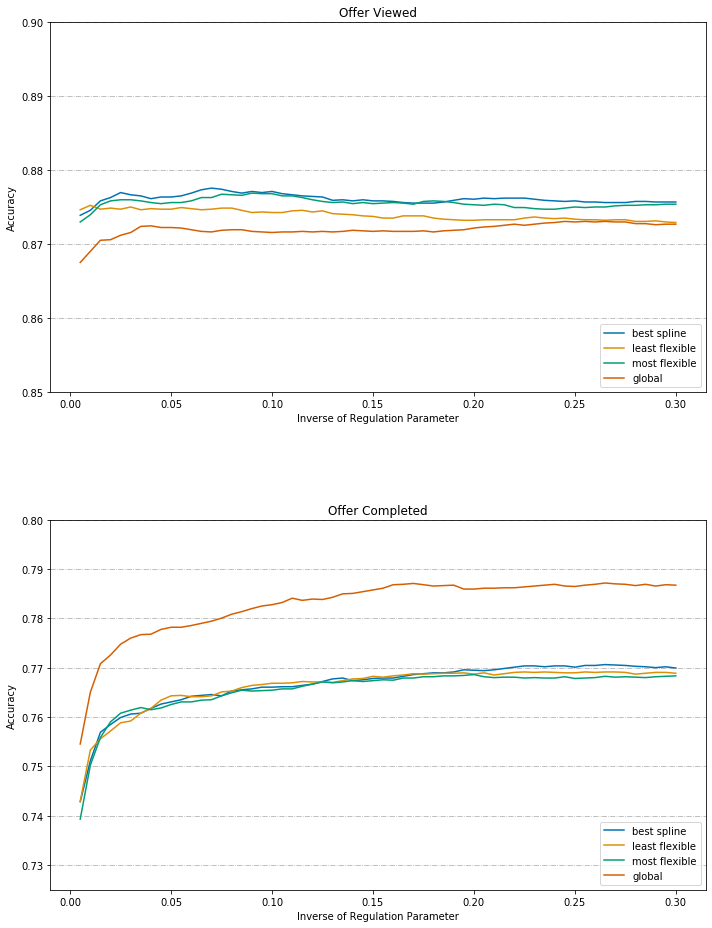

<Figure size 720x936 with 0 Axes>

In [307]:
vval_best = cv_viewed_res[(cv_viewed_res.param_splines__s1__df == 6) & 
                            (cv_viewed_res.param_splines__s2__df == 4) & 
                            (cv_viewed_res.param_splines__s3__df == 6)]
vval_least_flex = cv_viewed_res[(cv_viewed_res.param_splines__s1__df == 3) & 
                            (cv_viewed_res.param_splines__s2__df == 3) & 
                            (cv_viewed_res.param_splines__s3__df == 3)]
vval_most_flex = cv_viewed_res[(cv_viewed_res.param_splines__s1__df == 6) & 
                            (cv_viewed_res.param_splines__s2__df == 6) & 
                            (cv_viewed_res.param_splines__s3__df == 6)]
vval_global = cv_viewed_global_res
cval_best = cv_completed_res[(cv_completed_res.param_splines__s1__df == 4) & 
                            (cv_completed_res.param_splines__s2__df == 3) & 
                            (cv_completed_res.param_splines__s3__df == 3)]
cval_least_flex = cv_completed_res[(cv_completed_res.param_splines__s1__df == 3) & 
                            (cv_completed_res.param_splines__s2__df == 3) & 
                            (cv_completed_res.param_splines__s3__df == 3)]
cval_most_flex = cv_completed_res[(cv_completed_res.param_splines__s1__df == 6) & 
                            (cv_completed_res.param_splines__s2__df == 6) & 
                            (cv_completed_res.param_splines__s3__df == 6)]
cval_global = cv_completed_global_res

sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (10, 13)
fig = plt.Figure()

ax1 = plt.subplot(2, 1, 1)
sns.lineplot(vval_best.param_logit__C, vval_best.mean_test_score, ax=ax1, label='best spline')
sns.lineplot(vval_least_flex.param_logit__C, vval_least_flex.mean_test_score, ax=ax1, label='least flexible')
sns.lineplot(vval_most_flex.param_logit__C, vval_most_flex.mean_test_score, ax=ax1, label='most flexible')
sns.lineplot(vval_global.param_logit__C, vval_global.mean_test_score, ax=ax1, label='global')

plt.title('Offer Viewed', fontsize=12)
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Inverse of Regulation Parameter\n\n\n\n\n\n', fontsize=10)
plt.legend(loc=4)
ax1.set_ylim([0.85, 0.9])
plt.grid(axis='y', linestyle='-.', zorder=1)

ax2 = plt.subplot(2, 1, 2)
sns.lineplot(cval_best.param_logit__C, cval_best.mean_test_score, ax=ax2, label='best spline')
sns.lineplot(cval_least_flex.param_logit__C, cval_least_flex.mean_test_score, ax=ax2, label='least flexible')
sns.lineplot(cval_most_flex.param_logit__C, cval_most_flex.mean_test_score, ax=ax2, label='most flexible')
sns.lineplot(cval_global.param_logit__C, cval_global.mean_test_score, ax=ax2, label='global')
plt.title('Offer Completed', fontsize=12)
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Inverse of Regulation Parameter', fontsize=10)
plt.legend(loc=4)
ax2.set_ylim([0.725, 0.8])
plt.grid(axis='y', linestyle='-.', zorder=1)

plt.tight_layout()
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('graphs/cv.png', dpi=400, bbox_inches='tight')

In [66]:
# estimate selected models on the training data
# For offer viewing, I use the model with 3 degrees of freedom for each spline basis 
# and an inverse regulation parameter of 0.005
# For offer completion, I use the global cubic polynomial model with regulation parameter of 0.025

view_model = Pipeline([
    ('minmax', MinMaxScaler()),
    ('splines', ColumnTransformer(remainder='passthrough', transformers=[
        ('s1', NaturalSpline(df=3), 10),
        ('s2', NaturalSpline(df=3), 11),
        ('s3', NaturalSpline(df=3), 12)
    ])),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=200, C=0.005))
]).fit(Xv_train, viewed_train)

completion_model = Pipeline([
    ('minmax', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('logit', LogisticRegression(solver='lbfgs', max_iter=200, C=0.025))
]).fit(Xc_train, completed_train)

In [69]:
# get train error for selected models
vtrain_predictions = view_model.predict(Xv_train)
vtrain_error = accuracy_score(viewed_train, vtrain_predictions)
ctrain_predictions = completion_model.predict(Xc_train)
ctrain_error = accuracy_score(completed_train, ctrain_predictions)
print(f'View model train accuracy: {vtrain_error}')
print(f'Completion model train accuracy: {ctrain_error}')

View model test accuracy: 0.8772298006295908
Completion model test accuracy: 0.7782176475763174


In [101]:
# get test error for selected models
vt_predictions = view_model.predict(Xv_test)
vt_error = accuracy_score(viewed_test, vt_predictions)
ct_predictions = completion_model.predict(Xc_test)
ct_error = accuracy_score(completed_test, ct_predictions)
print(f'View model test accuracy: {vt_error}')
print(f'Completion model test accuracy: {ct_error}')

View model test accuracy: 0.8752528658125421
Completion model test accuracy: 0.7545526524148852


In [131]:
# get test error for selected model by offer for viewing
dodf = day_one.dropna()
for offer in ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_3f207df678b143eea3cee63160fa8bed',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_5a8bc65990b245e5a138643cd4eb9837',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']:
    idx = dodf[dodf[offer]==1].index
    dfX = Xv_test.loc[Xv_test.index.isin(idx),:]
    dfy = viewed_test[viewed_test.index.isin(idx)]
    df_predictions = view_model.predict(dfX)
    print(f'Sample size: {df_predictions.shape[0]}')
    df_error = accuracy_score(dfy, df_predictions)
    print(f'View model test accuracy for offer {offer}: {df_error}')
    print()

Sample size: 106
View model test accuracy for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.6698113207547169

Sample size: 109
View model test accuracy for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 0.9908256880733946

Sample size: 131
View model test accuracy for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.6564885496183206

Sample size: 104
View model test accuracy for offer offered_3f207df678b143eea3cee63160fa8bed: 0.625

Sample size: 96
View model test accuracy for offer offered_4d5c57ea9a6940dd891ad53e9dbe8da0: 0.9895833333333334

Sample size: 112
View model test accuracy for offer offered_5a8bc65990b245e5a138643cd4eb9837: 0.9285714285714286

Sample size: 100
View model test accuracy for offer offered_9b98b8c7a33c4b65b9aebfe6a799e6d9: 0.55

Sample size: 91
View model test accuracy for offer offered_ae264e3637204a6fb9bb56bc8210ddfd: 0.9010989010989011

Sample size: 108
View model test accuracy for offer offered_f19421c1d4aa40978ebb69ca19b0e20d: 0.9907407407407407

Sam

In [134]:
# get test error for selected model by offer for completion
dodf = day_one.dropna()
for offer in ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']:
    idx = dodf[dodf[offer]==1].index
    dfX = Xc_test.loc[Xc_test.index.isin(idx),:]
    dfy = completed_test[completed_test.index.isin(idx)]
    df_predictions = completion_model.predict(dfX)
    print(f'Sample size: {df_predictions.shape[0]}')
    df_error = accuracy_score(dfy, df_predictions)
    print(f'Completion model test accuracy for offer {offer}: {df_error}')
    print()

Sample size: 107
Completion model test accuracy for offer offered_0b1e1539f2cc45b7b9fa7c272da2e1d7: 0.6448598130841121

Sample size: 97
Completion model test accuracy for offer offered_2298d6c36e964ae4a3e7e9706d1fb8c2: 0.711340206185567

Sample size: 120
Completion model test accuracy for offer offered_2906b810c7d4411798c6938adc9daaa5: 0.625

Sample size: 106
Completion model test accuracy for offer offered_4d5c57ea9a6940dd891ad53e9dbe8da0: 0.6037735849056604

Sample size: 118
Completion model test accuracy for offer offered_9b98b8c7a33c4b65b9aebfe6a799e6d9: 0.6101694915254238

Sample size: 124
Completion model test accuracy for offer offered_ae264e3637204a6fb9bb56bc8210ddfd: 0.6048387096774194

Sample size: 112
Completion model test accuracy for offer offered_f19421c1d4aa40978ebb69ca19b0e20d: 0.7232142857142857

Sample size: 109
Completion model test accuracy for offer offered_fafdcd668e3743c1bb461111dcafc2a4: 0.7155963302752294



### Explore and Visualize Predictive Effect Heterogeneity

In [314]:
max_age = int(day_one.dropna().age.max())
max_income = int(day_one.dropna().income.max())
print(f'max age in full sample is: {max_age}')
print(f'max income in full sample is: {max_income}')
print()
min_age = int(day_one.dropna().age.min())
min_income = int(day_one.dropna().income.min())
print(f'min age in full sample is: {min_age}')
print(f'min income in full sample is: {min_income}')

max age in full sample is: 101
max income in full sample is: 120000

min age in full sample is: 18
min income in full sample is: 30000


In [227]:
# create lists for re-use (I should have done this earlier, probably!)
offer_list = ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_3f207df678b143eea3cee63160fa8bed',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_5a8bc65990b245e5a138643cd4eb9837',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']
offer_listc = ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offered_2906b810c7d4411798c6938adc9daaa5',
       'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offered_ae264e3637204a6fb9bb56bc8210ddfd',
       'offered_f19421c1d4aa40978ebb69ca19b0e20d',
       'offered_fafdcd668e3743c1bb461111dcafc2a4']
ages = list(range(101))
incomes = list(range(0, 121000, 1000))

In [228]:
# predict mean viewing probability by age for each offer
agev_proba = dict()
agev_mean_proba = dict()
for offer in offer_list:
    pseudo_Xt = Xv_test.copy()
    pseudo_Xt.loc[:, offer_list] = 0
    pseudo_Xt.loc[:, offer] = 1
    agev_mean_proba[offer] = list()
    for i in ages:
        pseudo_Xt.loc[:, 'age'] = i
        pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
        agev_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        agev_mean_proba[offer].append(mean_pseudo_pred)

In [229]:
# predict mean completion probability by age for each offer
agec_proba = dict()
agec_mean_proba = dict()
for offer in offer_listc:
    pseudo_Xt = Xc_test.copy()
    pseudo_Xt.loc[:, offer_listc] = 0
    pseudo_Xt.loc[:, offer] = 1
    agec_mean_proba[offer] = list()
    for i in ages:
        pseudo_Xt.loc[:, 'age'] = i
        pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
        agec_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        agec_mean_proba[offer].append(mean_pseudo_pred)

In [230]:
# predict mean viewing probability by income for each offer
incv_proba = dict()
incv_mean_proba = dict()
for offer in offer_list:
    pseudo_Xt = Xv_test.copy()
    pseudo_Xt.loc[:, offer_list] = 0
    pseudo_Xt.loc[:, offer] = 1
    incv_mean_proba[offer] = list()
    for i in incomes:
        pseudo_Xt.loc[:, 'income'] = i
        pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
        incv_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        incv_mean_proba[offer].append(mean_pseudo_pred)

In [236]:
# predict mean completion probability by income for each offer
incc_proba = dict()
incc_mean_proba = dict()
for offer in offer_listc:
    pseudo_Xt = Xc_test.copy()
    pseudo_Xt.loc[:, offer_listc] = 0
    pseudo_Xt.loc[:, offer] = 1
    incc_mean_proba[offer] = list()
    for i in incomes:
        pseudo_Xt.loc[:, 'income'] = i
        pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
        incc_proba[(offer, i)] = pseudo_preds
        mean_pseudo_pred = pseudo_preds.mean()
        incc_mean_proba[offer].append(mean_pseudo_pred)

In [317]:
# predict mean viewing probability by gender for each offer
genv_mean_proba = dict()
genv_mean_proba['offers'] = list()
genv_mean_proba['genders'] = list()
genv_mean_proba['means'] = list()
for offer in offer_list:
    offer_id = offer_list.index(offer)+1
    pseudo_Xt = Xv_test.copy()
    pseudo_Xt.loc[:, offer_list] = 0
    pseudo_Xt.loc[:, offer] = 1
    
    pseudo_Xt.loc[:, 'gender_F'] = 1
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
    genv_mean_proba['offers'].append(offer_id)
    genv_mean_proba['genders'].append('Female')
    genv_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 1
    pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
    genv_mean_proba['offers'].append(offer_id)
    genv_mean_proba['genders'].append('Non-Binary')
    genv_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*view_model.predict_proba(pseudo_Xt)))[1])
    genv_mean_proba['offers'].append(offer_id)
    genv_mean_proba['genders'].append('Male')
    genv_mean_proba['means'].append(pseudo_preds.mean())
    
genv_df = pd.DataFrame(genv_mean_proba)
genv_df.to_csv('prediction_results/gender_view_results.csv')

In [318]:
# predict mean completion probability by gender for each offer
genc_mean_proba = dict()
genc_mean_proba['offers'] = list()
genc_mean_proba['genders'] = list()
genc_mean_proba['means'] = list()
for offer in offer_listc:
    offer_id = offer_list.index(offer)+1
    pseudo_Xt = Xc_test.copy()
    pseudo_Xt.loc[:, offer_listc] = 0
    pseudo_Xt.loc[:, offer] = 1
    
    pseudo_Xt.loc[:, 'gender_F'] = 1
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
    genc_mean_proba['offers'].append(offer_id)
    genc_mean_proba['genders'].append('Female')
    genc_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 1
    pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
    genc_mean_proba['offers'].append(offer_id)
    genc_mean_proba['genders'].append('Non-Binary')
    genc_mean_proba['means'].append(pseudo_preds.mean())
    
    pseudo_Xt.loc[:, 'gender_F'] = 0
    pseudo_Xt.loc[:, 'gender_O'] = 0
    pseudo_preds = np.array(list(zip(*completion_model.predict_proba(pseudo_Xt)))[1])
    genc_mean_proba['offers'].append(offer_id)
    genc_mean_proba['genders'].append('Male')
    genc_mean_proba['means'].append(pseudo_preds.mean())
    
genc_df = pd.DataFrame(genc_mean_proba)
genc_df.to_csv('prediction_results/gender_completion_results.csv')

c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\krist\pycharmprojects\starbuckscapstone\venv\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes usi

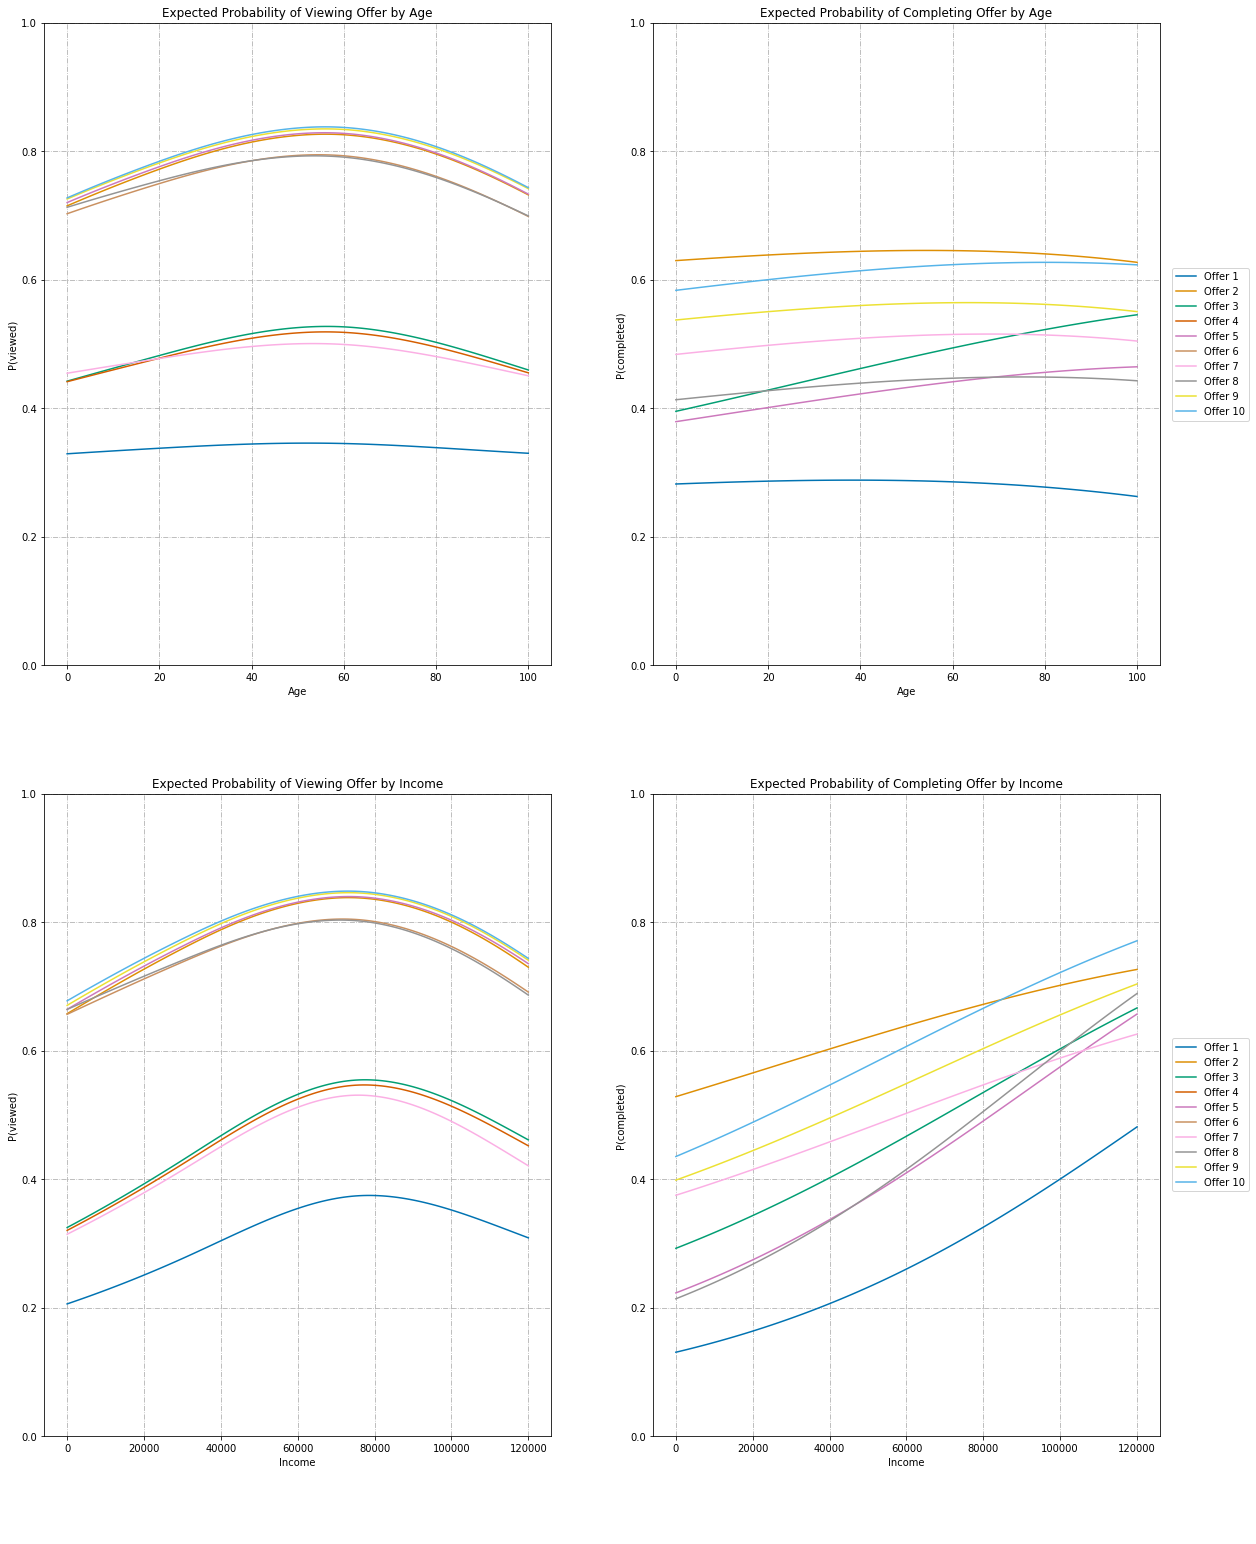

<Figure size 1440x1872 with 0 Axes>

In [308]:
# Visualize change in mean probability of viewing and completing offers by age and income
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (20, 26)
fig = plt.Figure()

# age viewing
for offer, i in zip(offer_list, range(1,11)):
    ax1_age = plt.subplot(2, 2, 1)
    sns.lineplot(ages, agev_mean_proba[offer], ax=ax1_age, label=f'Offer {i}')
plt.title('Expected Probability of Viewing Offer by Age', fontsize=12)
plt.ylabel('P(viewed)', fontsize=10)
plt.xlabel('Age\n\n\n\n\n\n', fontsize=10)
plt.legend(loc='center', bbox_to_anchor=(2.3, 0.5))
plt.grid(linestyle='-.', zorder=1)
ax1_age.set_ylim([0, 1])

# age completion
for offer, i in zip(offer_list, range(1,11)):
    ax2_age = plt.subplot(2, 2, 2)
    if offer in offer_listc:
        sns.lineplot(ages, agec_mean_proba[offer], ax=ax2_age, label=f'Offer {i}')
    else:
        sns.lineplot(ages, np.zeros(len(ages)), ax=ax2_age, label=f'Offer {i}', alpha=0)
plt.title('Expected Probability of Completing Offer by Age', fontsize=12)
plt.ylabel('P(completed)', fontsize=10)
plt.xlabel('Age\n\n\n\n\n\n', fontsize=10)
ax2_age.get_legend().remove()
plt.grid(linestyle='-.', zorder=1)
ax2_age.set_ylim([0, 1])

# income viewing
for offer, i in zip(offer_list, range(1,11)):
    ax1_inc = plt.subplot(2, 2, 3)
    sns.lineplot(incomes, incv_mean_proba[offer], ax=ax1_inc, label=f'Offer {i}')
plt.title('Expected Probability of Viewing Offer by Income', fontsize=12)
plt.ylabel('P(viewed)', fontsize=10)
plt.xlabel('Income\n\n\n\n\n\n', fontsize=10)
plt.legend(loc='center', bbox_to_anchor=(2.3, 0.5))
plt.grid(linestyle='-.', zorder=1)
ax1_inc.set_ylim([0, 1])

# income completion
for offer, i in zip(offer_list, range(1,11)):
    ax2_inc = plt.subplot(2, 2, 4)
    if offer in offer_listc:
        sns.lineplot(incomes, incc_mean_proba[offer], ax=ax2_inc, label=f'Offer {i}')
    else:
        sns.lineplot(incomes, np.zeros(len(incomes)), ax=ax2_inc, label=f'Offer {i}', alpha=0)
plt.title('Expected Probability of Completing Offer by Income', fontsize=12)
plt.ylabel('P(completed)', fontsize=10)
plt.xlabel('Income\n\n\n\n\n\n', fontsize=10)
ax2_inc.get_legend().remove()
plt.grid(linestyle='-.', zorder=1)
ax2_inc.set_ylim([0, 1])

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('graphs/mean_proba_ageinc.png', dpi=400, bbox_inches='tight')

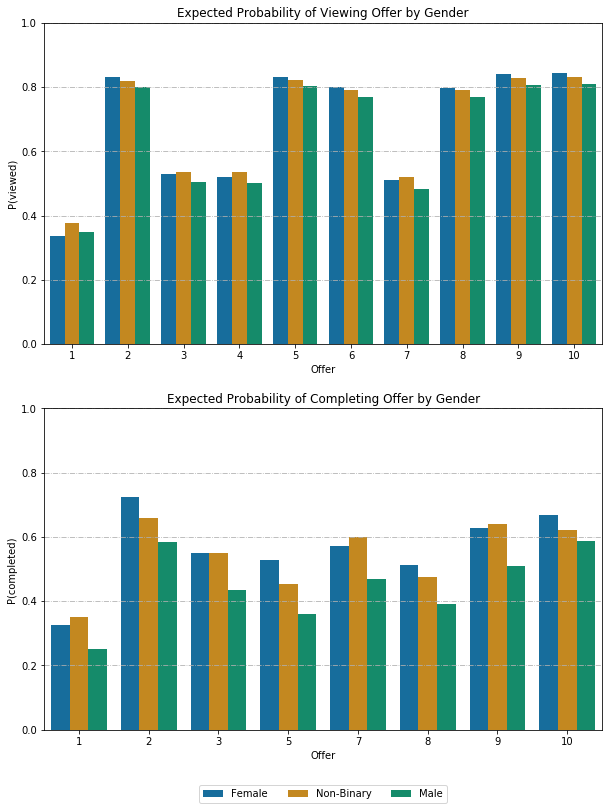

<Figure size 720x936 with 0 Axes>

In [312]:
# Visualize change in mean probability of viewing and completing offers by gender
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (10, 13)
fig = plt.Figure()

# gender viewing
ax1_gen = plt.subplot(2, 1, 1)
sns.barplot(genv_df.offers, genv_df.means, hue=genv_df.genders, ax=ax1_gen)
plt.title('Expected Probability of Viewing Offer by Gender', fontsize=12)
plt.ylabel('P(viewed)', fontsize=10)
plt.xlabel('Offer', fontsize=10)
ax1_gen.get_legend().remove()
plt.grid(axis='y', linestyle='-.', zorder=1)
ax1_gen.set_ylim([0, 1])

# gender completion
ax2_gen = plt.subplot(2, 1, 2)
sns.barplot(genc_df.offers, genc_df.means, hue=genc_df.genders, ax=ax2_gen)
plt.title('Expected Probability of Completing Offer by Gender', fontsize=12)
plt.ylabel('P(completed)', fontsize=10)
plt.xlabel('Offer', fontsize=10)
#plt.legend(loc='center', bbox_to_anchor=(1.1, 0.5))
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.grid(axis='y', linestyle='-.', zorder=1)
ax2_gen.set_ylim([0, 1])

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('graphs/mean_proba_gender.png', dpi=400, bbox_inches='tight')